In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from keras import metrics
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.preprocessing.text import Tokenizer

In [3]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# Data Cleansing

In [4]:
# define path and get csv file
path = 'Spam_Text_Message_Classification/SPAM text message 20170820 - Data.csv'
df = pd.read_csv(path)

In [5]:
df.info

<bound method DataFrame.info of      Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [6]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Make sure there are no NAN values in the data frame
df.isnull().values.any()

False

# Data Preparation

In [29]:
# replace Category 
dict_trans = {'ham' : 0, 'spam': 1}
df = df.replace({"Category": dict_trans})
df

,Category,Message,Message_without_stopwords
0,0,"Go until jurong point, crazy.. Available only ...","Go jurong point, crazy.. Available bugis n gre..."
1,0,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry 2 wkly comp win FA Cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,U dun say early hor... U c already say...
4,0,"Nah I don't think he goes to usf, he lives aro...","Nah I think goes usf, lives around though"
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,This 2nd time tried 2 contact u. U £750 Pound ...
5568,0,Will ü b going to esplanade fr home?,Will ü b going esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s...","Pity, * mood that. So...any suggestions?"
5570,0,The guy did some bitching but I acted like i'd...,The guy bitching I acted like i'd interested b...


In [31]:
df.loc[df['Category'] == 1, 'Message_without_stopwords']

2       Free entry 2 wkly comp win FA Cup final tkts 2...
5       FreeMsg Hey darling 3 week's word back! I'd li...
8       WINNER!! As valued network customer selected r...
9       Had mobile 11 months more? U R entitled Update...
11      SIX chances win CASH! From 100 20,000 pounds t...
                              ...                        
5537    Want explicit SEX 30 secs? Ring 02073162414 no...
5540    ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547    Had contract mobile 11 Mnths? Latest Motorola,...
5566    REMINDER FROM O2: To get 2.50 pounds free call...
5567    This 2nd time tried 2 contact u. U £750 Pound ...
Name: Message_without_stopwords, Length: 747, dtype: object

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df2 = pd.DataFrame(df)
df2.columns = ["Category","Message"]

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df2['Message_without_stopwords'] = df2['Message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df2)

      Category                                            Message  \
0            0  Go until jurong point, crazy.. Available only ...   
1            0                      Ok lar... Joking wif u oni...   
2            1  Free entry in 2 a wkly comp to win FA Cup fina...   
3            0  U dun say so early hor... U c already then say...   
4            0  Nah I don't think he goes to usf, he lives aro...   
...        ...                                                ...   
5567         1  This is the 2nd time we have tried 2 contact u...   
5568         0               Will ü b going to esplanade fr home?   
5569         0  Pity, * was in mood for that. So...any other s...   
5570         0  The guy did some bitching but I acted like i'd...   
5571         0                         Rofl. Its true to its name   

                              Message_without_stopwords  
0     Go jurong point, crazy.. Available bugis n gre...  
1                         Ok lar... Joking wif u oni...

[nltk_data] Downloading package stopwords to C:\Users\Kevin
[nltk_data]     Bollier\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# create the tokenizer
s = Tokenizer()
# fit the tokenizer on the documents
s.fit_on_texts(df.loc[df['Category'] == 1, 'Message_without_stopwords'])

pd_word_counts_s = pd.DataFrame(s.word_counts, index=[0])
pd_word_shaped_s = pd.DataFrame(pd_word_counts_s.max().sort_values(ascending=False))

pd_word_max_s = pd_word_shaped_s.iloc[:10,:]
pd_word_max_s

,0
call,352
free,224
2,194
u,164
txt,163
ur,144
now,138
4,133
mobile,127
you,126


In [11]:
# create the tokenizer
h = Tokenizer()
# fit the tokenizer on the documents
h.fit_on_texts(df.loc[df['Category'] == 0, 'Message_without_stopwords'])

pd_word_counts_h = pd.DataFrame(h.word_counts, index=[0])
pd_word_shaped_h = pd.DataFrame(pd_word_counts_h.max().sort_values(ascending=False))

pd_word_max_h = pd_word_shaped_h.iloc[:10,:]
pd_word_max_h

,0
i,1569
u,1019
you,402
i'm,386
2,326
gt,318
lt,316
get,305
ok,283
go,252


In [12]:
pd_free_call = pd.DataFrame()
if 'free' in pd_word_counts_h.columns and 'call' in pd_word_counts_h.columns and 'now' in pd_word_counts_h.columns:
        pd_free_call = pd_free_call.append([pd_word_counts_h["free"], pd_word_counts_h["call"], pd_word_counts_h["now"]])
        
pd_free_call    

,0
free,60
call,238
now,174


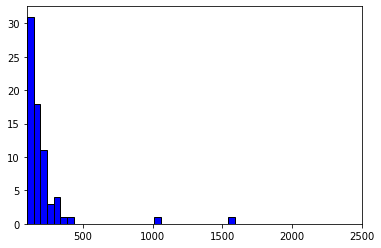

In [13]:
plt.hist(pd_word_shaped_h[0], color = 'blue', edgecolor = 'black', bins=50, range=(100, 2500))
plt.xlim(100, 2500)
plt.show()

In [14]:
# divide into features and target variables
x_values = df["Message"].values
y = df["Category"].values

In [15]:
# create the tfidf vectorizer and apply it on the train set
tfidf_vectorizer = TfidfVectorizer(use_idf = True)
tfidf_vectors = tfidf_vectorizer.fit_transform(x_values)
tfidf_vectors = tfidf_vectors.toarray()

In [16]:
np.unique(tfidf_vectors)

array([0.000, 0.023, 0.027, ..., 0.979, 0.979, 1.000])

In [17]:
tfidf_vectorizer.get_feature_names()

['00',
 '000',
 '000pes',
 '008704050406',
 '0089',
 '0121',
 '01223585236',
 '01223585334',
 '0125698789',
 '02',
 '0207',
 '02072069400',
 '02073162414',
 '02085076972',
 '021',
 '03',
 '04',
 '0430',
 '05',
 '050703',
 '0578',
 '06',
 '07',
 '07008009200',
 '07046744435',
 '07090201529',
 '07090298926',
 '07099833605',
 '07123456789',
 '0721072',
 '07732584351',
 '07734396839',
 '07742676969',
 '07753741225',
 '0776xxxxxxx',
 '07781482378',
 '07786200117',
 '077xxx',
 '078',
 '07801543489',
 '07808',
 '07808247860',
 '07808726822',
 '07815296484',
 '07821230901',
 '078498',
 '07880867867',
 '0789xxxxxxx',
 '07946746291',
 '0796xxxxxx',
 '07973788240',
 '07xxxxxxxxx',
 '08',
 '0800',
 '08000407165',
 '08000776320',
 '08000839402',
 '08000930705',
 '08000938767',
 '08001950382',
 '08002888812',
 '08002986030',
 '08002986906',
 '08002988890',
 '08006344447',
 '0808',
 '08081263000',
 '08081560665',
 '0825',
 '083',
 '0844',
 '08448350055',
 '08448714184',
 '0845',
 '08450542832',
 '084

In [19]:
# split into train and test data
x_train, x_test, y_train, y_test = train_test_split(tfidf_vectors, y, test_size=0.3, random_state=42)

In [20]:
np.unique(x_train)

array([0.000, 0.027, 0.028, ..., 0.927, 0.979, 1.000])

In [21]:
print("Train data:", "0: ", (y_train == 0).sum(), "1: ", (y_train == 1).sum(), "unique values: ", ', '.join([str(i) for i in np.unique(y_train)]))

Train data: 0:  3377 1:  523 unique values:  0, 1


In [22]:
print("Test data:", "0: ", (y_test == 0).sum(), "1: ", (y_test == 1).sum(), "unique values: ", ', '.join([str(i) for i in np.unique(y_test)]))

Test data: 0:  1448 1:  224 unique values:  0, 1


# Build Model

In [23]:
# build the model
model = keras.Sequential(
    [
        layers.Dense(8, activation="relu", 
                     input_shape=[x_train.shape[1]], 
                     name="layer1"),
        layers.Dense(8, activation="relu", 
                     name="layer2"),
        layers.Dense(1, activation="sigmoid", 
                     name="layer3")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 8)                 69680     
_________________________________________________________________
layer2 (Dense)               (None, 8)                 72        
_________________________________________________________________
layer3 (Dense)               (None, 1)                 9         
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Model compilation
sLossMetric = "binary_crossentropy"            
model.compile(loss = sLossMetric,
            optimizer = RMSprop(learning_rate=0.01),
            metrics=["accuracy"])

In [25]:
history = model.fit(x = x_train, y = y_train, epochs = 10, validation_split=0.2, verbose=1)

Epoch 1/10
98/98 [==============================] - 1s 4ms/step - loss: 0.1597 - accuracy: 0.9449 - val_loss: 0.0785 - val_accuracy: 0.9756
Epoch 2/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0323 - accuracy: 0.9907 - val_loss: 0.0787 - val_accuracy: 0.9782
Epoch 3/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0125 - accuracy: 0.9952 - val_loss: 0.0887 - val_accuracy: 0.9795
Epoch 4/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.1115 - val_accuracy: 0.9795
Epoch 5/10
98/98 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.1373 - val_accuracy: 0.9782
Epoch 6/10
98/98 [==============================] - 0s 3ms/step - loss: 1.8909e-04 - accuracy: 1.0000 - val_loss: 0.1285 - val_accuracy: 0.9795
Epoch 7/10
98/98 [==============================] - 0s 3ms/step - loss: 1.2529e-04 - accuracy: 1.0000 - val_loss: 0.1577 - val_accuracy: 0.9782
Epoch 8/10
9

In [ ]:
history.history.keys() 

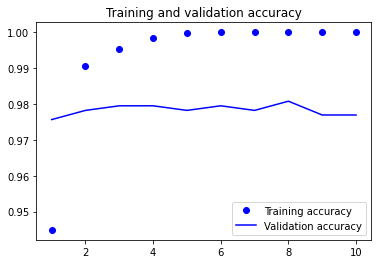

In [26]:
# Plot training performance
import matplotlib.pyplot as plt
%matplotlib inline
mse = history.history['accuracy']
val_mse = history.history['val_accuracy']
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'bo', label='Training accuracy')
plt.plot(epochs, val_mse, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

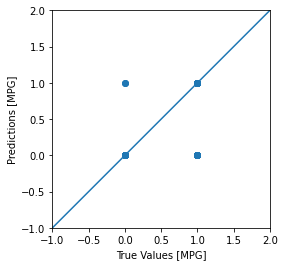

In [27]:
# Make predictions
test_predictions = model.predict(x_test).flatten()
test_predictions = (test_predictions > .5).astype(int)

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [-1, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

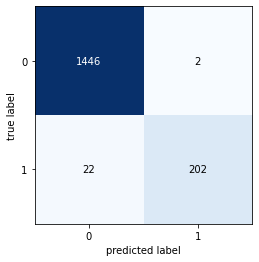

In [28]:
mat = confusion_matrix(y_test, test_predictions)
plot_confusion_matrix(conf_mat=mat)